# From Data to Diagnosis
### Building a Machine Learning Pipeline for Thalassemia Classification

**Author:** Konstantinos Kalaitzidis and Evanthia Chatzigeorgiou 
**Dataset:** [Mendeley Thalassemia Dataset](https://data.mendeley.com/datasets/p8rv84hrbs/1)

---

## 1. Introduction
The goal of this notebook is to build a simple, end-to-end ML pipeline that predicts whether a patient is likely to have thalassemia based on clinical features.


In [17]:
# setup
import pandas as pd # for handling and analyzing structured data
import numpy as np # for numerical operations — fast array math and linear algebra
import matplotlib.pyplot as plt # basic plotting library
import seaborn as sns # statistical data visualization built on top of matplotlib
from sklearn.model_selection import train_test_split, GridSearchCV # for splitting data and hyperparameter tuning
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.linear_model import LogisticRegression # a linear model for binary or multiclass classification.
from sklearn.ensemble import RandomForestClassifier # an ensemble learning method for classification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score # for evaluating model performance
import joblib # for saving and loading machine learning models

print("Libraries imported successfully.")

Libraries imported successfully.


In [21]:
import os

# path to dataset
DATA_PATH = "../data/raw/thalassimia.xlsx"  

# Load dataset
try:
    df = pd.read_excel(DATA_PATH)
    print("✅ Loaded dataset successfully from:", DATA_PATH)
    print("Shape:", df.shape)
    display(df.head(10))
except FileNotFoundError:
    print("❌ File not found at:", DATA_PATH)
    print("Please download the dataset from:")
    print("https://data.mendeley.com/datasets/p8rv84hrbs/1")
    print("and place it at data/raw/thalassemia.xlsx")


✅ Loaded dataset successfully from: ../data/raw/thalassimia.xlsx
Shape: (1073, 18)


,ID,Gender,Age,MCV,HBG,MCH,RBC,S,HBA2,HBA,HBF,Iron,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,1,1,30.0,63.9,11.5,20.4,NaN,NaN,5.8,92.1,1.7,9.6,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,14.0,62.0,7.0,17.8,NaN,NaN,2.2,97.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,29.0,72.0,16.8,24.1,NaN,NaN,3.5,96.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,27.0,61.0,8.5,24.6,NaN,NaN,2.3,97.6,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,2.0,53.6,8.9,17.0,NaN,NaN,2.5,97.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,0,8.0,59.2,9.7,18.8,NaN,NaN,5.5,92.1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,1,23.0,69.7,16.1,27.4,NaN,NaN,2.8,97.2,NaN,NaN,NaN,NaN,NaN,NaN,ذكر,1.0
7,8,0,17.0,77.9,10.4,26.1,NaN,NaN,2.7,97.1,NaN,0.7,NaN,NaN,NaN,NaN,انثى,0.0
8,9,0,36.0,64.0,10.9,20.8,NaN,NaN,5,92.0,2.9,15.4,NaN,NaN,NaN,NaN,NaN,NaN
9,10,1,17.0,66.8,11.9,20.6,NaN,NaN,4.9,94.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Basic info: dtypes, missing values, descriptive stats
print("Columns and dtypes:")
display(df.dtypes)

print("\nMissing values per column:")
display(df.isna().sum())

print("\nDescriptive statistics (numeric):")
display(df.describe().T)


Columns and dtypes:


ID               int64
Gender           int64
Age            float64
MCV            float64
HBG            float64
MCH            float64
RBC            float64
S              float64
HBA2            object
HBA            float64
HBF            float64
Iron           float64
Unnamed: 12    float64
Unnamed: 13    float64
Unnamed: 14    float64
Unnamed: 15    float64
Unnamed: 16     object
Unnamed: 17    float64
dtype: object


Missing values per column:


ID                0
Gender            0
Age               0
MCV              19
HBG              19
MCH              41
RBC             926
S              1054
HBA2              5
HBA               4
HBF             585
Iron            827
Unnamed: 12    1073
Unnamed: 13    1073
Unnamed: 14    1073
Unnamed: 15    1073
Unnamed: 16    1071
Unnamed: 17    1071
dtype: int64


Descriptive statistics (numeric):


,count,mean,std,min,25%,50%,75%,max
ID,1073.0,537.000000,309.892723,1.0,269.00,537.0,805.000,1073.0
Gender,1073.0,0.387698,0.487452,0.0,0.00,0.0,1.000,1.0
Age,1073.0,20.479031,15.110963,1.0,9.00,20.0,29.000,221.0
MCV,1054.0,68.759583,17.792284,2.0,60.00,67.6,77.000,488.0
HBG,1054.0,11.642808,8.199484,1.3,9.20,11.0,12.275,125.0
MCH,1032.0,22.971221,11.741189,3.9,19.30,22.0,26.000,319.0
RBC,147.0,5.434762,2.664376,1.8,4.40,5.0,5.800,23.9
S,19.0,39.926316,8.288603,30.6,37.20,38.0,39.600,70.3
HBA,1069.0,96.722357,59.938013,0.0,93.80,96.8,97.400,981.0
HBF,488.0,5.959795,16.750269,0.3,0.80,1.3,3.100,99.0


In [23]:
# Drop ID and unnamed columns
df = df.drop(columns=["ID"] + [c for c in df.columns if "Unnamed" in c])
print("Remaining columns:")
display(df.head(3))


Remaining columns:


,Gender,Age,MCV,HBG,MCH,RBC,S,HBA2,HBA,HBF,Iron
0,1,30.0,63.9,11.5,20.4,NaN,NaN,5.8,92.1,1.7,9.6
1,0,14.0,62.0,7.0,17.8,NaN,NaN,2.2,97.8,NaN,NaN
2,1,29.0,72.0,16.8,24.1,NaN,NaN,3.5,96.3,NaN,NaN


In [24]:
# Create target column based on S
df['Target'] = df['S'].apply(lambda x: 1 if x > 0 else 0)

# Check class balance
print("Class counts (Target):")
display(df['Target'].value_counts())
print("\nClass proportions:")
display(df['Target'].value_counts(normalize=True).rename("proportion"))

Class counts (Target):


Target
0    1054
1      19
Name: count, dtype: int64


Class proportions:


Target
0    0.982293
1    0.017707
Name: proportion, dtype: float64

In [26]:
# Basic info
print("Shape:", df.shape)
print("\nData types:\n")
print(df.dtypes)

# Quick statistics
print("\nDescriptive statistics:\n")
display(df.describe())

# Check missing values
print("\nMissing values per column:\n")
display(df.isnull().sum())

Shape: (1073, 12)

Data types:

Gender      int64
Age       float64
MCV       float64
HBG       float64
MCH       float64
RBC       float64
S         float64
HBA2       object
HBA       float64
HBF       float64
Iron      float64
Target      int64
dtype: object

Descriptive statistics:



,Gender,Age,MCV,HBG,MCH,RBC,S,HBA,HBF,Iron,Target
count,1073.000000,1073.000000,1054.000000,1054.000000,1032.000000,147.000000,19.000000,1069.000000,488.000000,246.000000,1073.000000
mean,0.387698,20.479031,68.759583,11.642808,22.971221,5.434762,39.926316,96.722357,5.959795,10.213923,0.017707
std,0.487452,15.110963,17.792284,8.199484,11.741189,2.664376,8.288603,59.938013,16.750269,8.481105,0.131947
min,0.000000,1.000000,2.000000,1.300000,3.900000,1.800000,30.600000,0.000000,0.300000,0.100000,0.000000
25%,0.000000,9.000000,60.000000,9.200000,19.300000,4.400000,37.200000,93.800000,0.800000,3.800000,0.000000
50%,0.000000,20.000000,67.600000,11.000000,22.000000,5.000000,38.000000,96.800000,1.300000,8.200000,0.000000
75%,1.000000,29.000000,77.000000,12.275000,26.000000,5.800000,39.600000,97.400000,3.100000,14.225000,0.000000
max,1.000000,221.000000,488.000000,125.000000,319.000000,23.900000,70.300000,981.000000,99.000000,55.000000,1.000000



Missing values per column:



Gender       0
Age          0
MCV         19
HBG         19
MCH         41
RBC        926
S         1054
HBA2         5
HBA          4
HBF        585
Iron       827
Target       0
dtype: int64

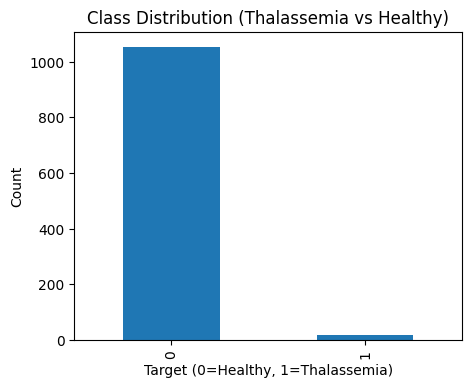

In [27]:
# Visualize class distribution
plt.figure(figsize=(5,4))
df['Target'].value_counts().plot(kind='bar')
plt.title('Class Distribution (Thalassemia vs Healthy)')
plt.xlabel('Target (0=Healthy, 1=Thalassemia)')
plt.ylabel('Count')
plt.show()


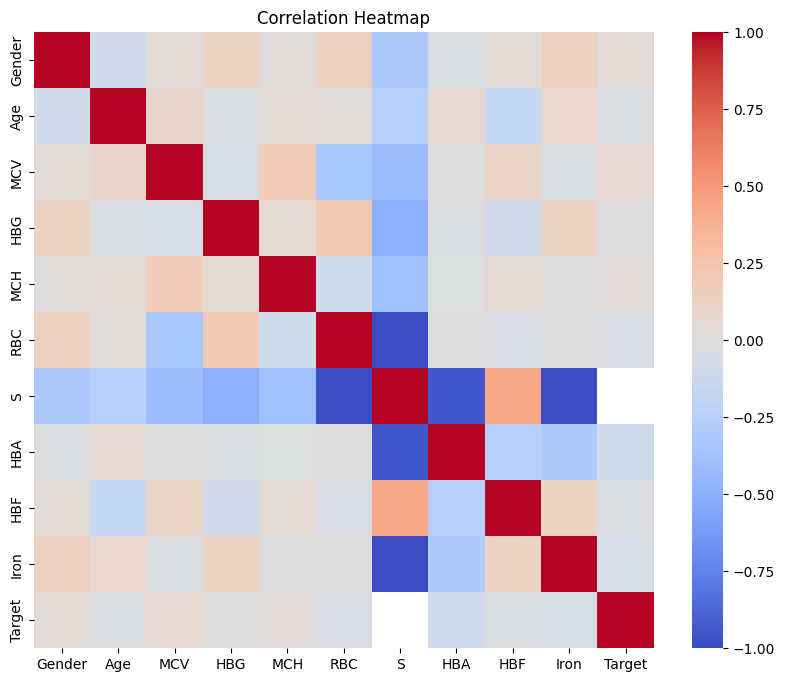

In [28]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

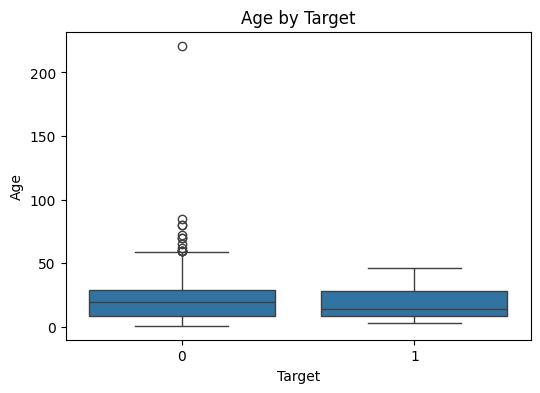

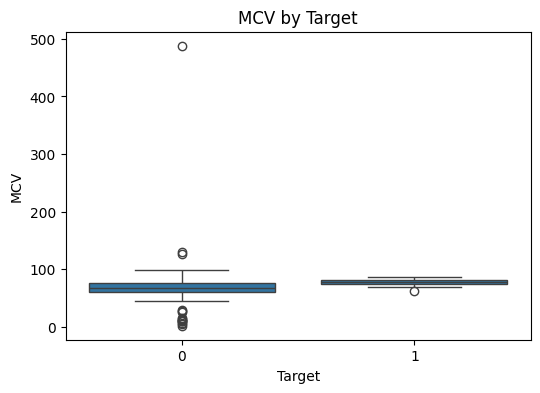

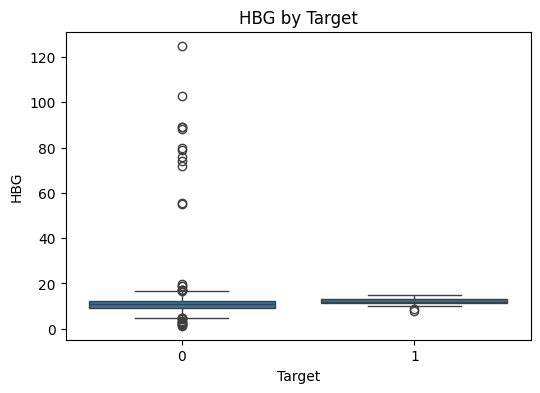

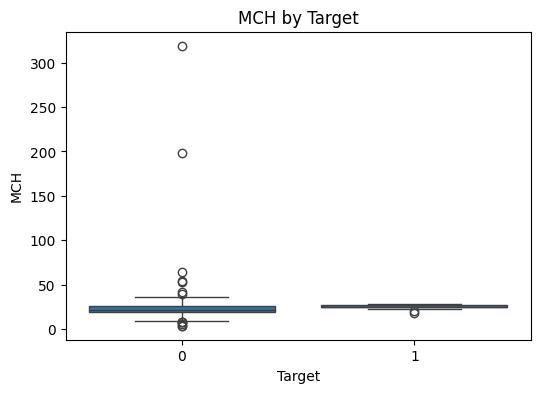

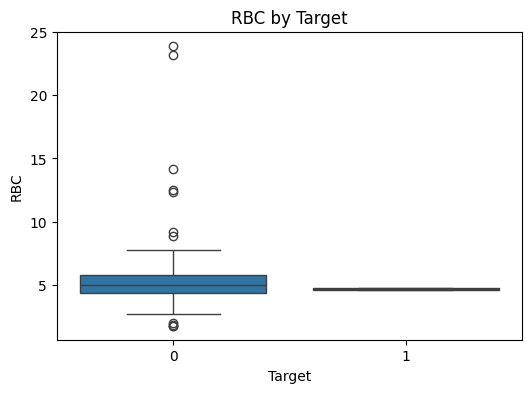

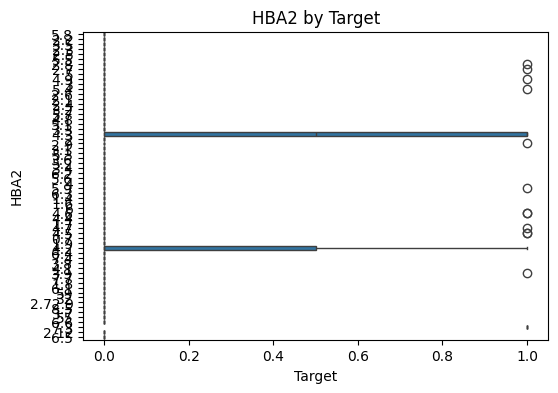

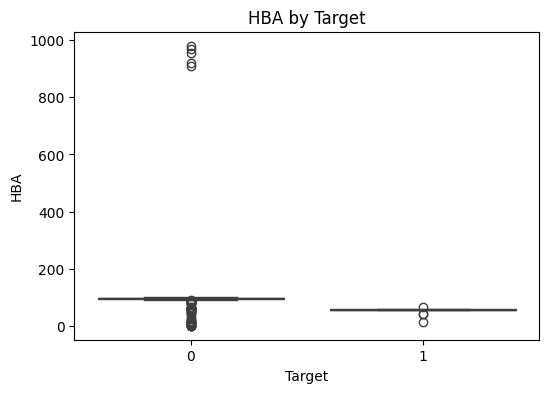

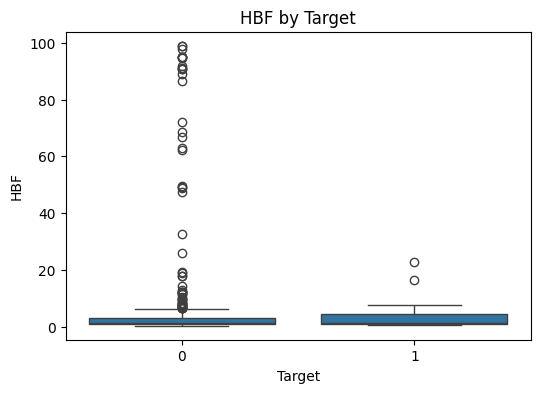

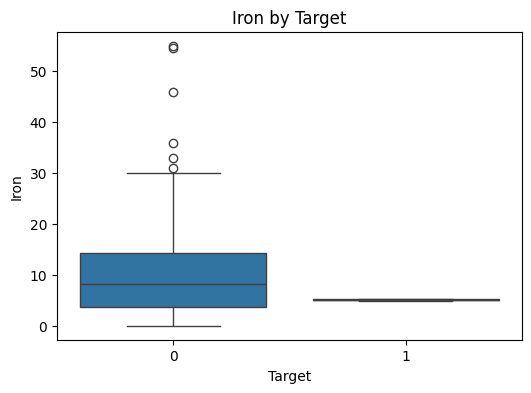

In [29]:
numerical_cols = ['Age', 'MCV', 'HBG', 'MCH', 'RBC', 'HBA2', 'HBA', 'HBF', 'Iron']

for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='Target', y=col)
    plt.title(f'{col} by Target')
    plt.show()

In [30]:
corr_with_target = df.corr(numeric_only=True)['Target'].sort_values(ascending=False)
display(corr_with_target)

Target    1.000000
MCV       0.066150
Gender    0.038198
MCH       0.025619
HBG       0.004513
Age      -0.008937
HBF      -0.016529
RBC      -0.032499
Iron     -0.053633
HBA      -0.097522
S              NaN
Name: Target, dtype: float64

In [33]:
# --- Clean numeric columns with invalid characters ---
# Convert all numeric-looking columns to proper floats
for col in df.columns:
    if col not in ['Target']:  # skip target
        df[col] = (
            df[col]
            .astype(str)                        # convert everything to string first
            .str.replace('[^0-9\.\-]', '', regex=True)  # keep only numbers, dots, minus signs
            .replace('', np.nan)                 # empty strings -> NaN
        )
        df[col] = pd.to_numeric(df[col], errors='coerce')  # convert valid ones to float, others -> NaN

# Now recheck missing values
print("Missing values after cleaning:")
print(df.isna().sum())

# Fill remaining NaNs with column mean
df = df.fillna(df.mean(numeric_only=True))


Missing values after cleaning:
Gender    0
Age       0
MCV       0
HBG       0
MCH       0
RBC       0
S         0
HBA2      0
HBA       0
HBF       0
Iron      0
Target    0
dtype: int64


In [34]:
# --- Data Cleaning ---
# Drop ID and unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

# Check missing values
print("Missing values per column:")
print(df.isna().sum())

# Drop rows with too many NaNs (e.g., >20%)
threshold = int(0.2 * len(df.columns))
df = df.dropna(thresh=threshold)

# Impute remaining missing values with column mean
df = df.fillna(df.mean(numeric_only=True))

# --- Verify numeric types ---
df = df.apply(pd.to_numeric, errors='ignore')

# --- Normalization ---
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop(columns=['Target'])
y = df['Target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Put back into a DataFrame for easy use
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("✅ Data cleaned and normalized.")
display(X_scaled.head())


Missing values per column:
Gender    0
Age       0
MCV       0
HBG       0
MCH       0
RBC       0
S         0
HBA2      0
HBA       0
HBF       0
Iron      0
Target    0
dtype: int64
✅ Data cleaned and normalized.


/var/folders/4n/41px7rn169s5k2y3v36v4l740000gn/T/ipykernel_47146/2142339375.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,Gender,Age,MCV,HBG,MCH,RBC,S,HBA2,HBA,HBF,Iron
0,1.256713,0.630364,-0.275710,-0.017581,-0.223408,-9.037080e-16,0.0,0.784635,-0.077299,-3.774873e-01,-0.151488
1,-0.795727,-0.428964,-0.383507,-0.571584,-0.449316,-9.037080e-16,0.0,-0.521073,0.018021,-7.870708e-17,0.000000
2,1.256713,0.564156,0.183846,0.634910,0.098077,-9.037080e-16,0.0,-0.049567,-0.007063,-7.870708e-17,0.000000
3,-0.795727,0.431740,-0.440243,-0.386916,0.141521,-9.037080e-16,0.0,-0.484804,0.014677,-7.870708e-17,-2.495652
4,1.256713,-1.223459,-0.860085,-0.337672,-0.518826,-9.037080e-16,0.0,-0.412264,0.013004,-7.870708e-17,0.000000


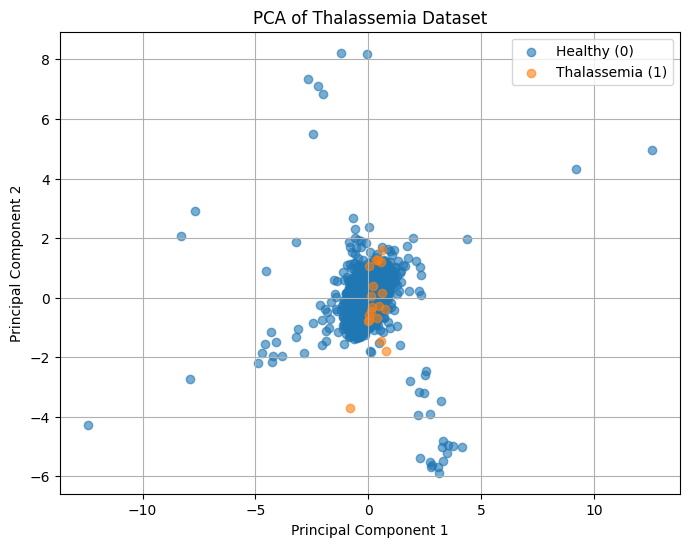

Explained variance ratio: [0.11943092 0.11672755]


In [35]:
from sklearn.decomposition import PCA

# Reduce to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Target'] = y.values

# Plot
plt.figure(figsize=(8,6))
plt.scatter(
    pca_df[pca_df['Target']==0]['PC1'], pca_df[pca_df['Target']==0]['PC2'],
    alpha=0.6, label='Healthy (0)'
)
plt.scatter(
    pca_df[pca_df['Target']==1]['PC1'], pca_df[pca_df['Target']==1]['PC2'],
    alpha=0.6, label='Thalassemia (1)'
)
plt.title("PCA of Thalassemia Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

# Variance explained
print("Explained variance ratio:", pca.explained_variance_ratio_)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- Split the data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# --- Logistic Regression ---
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:,1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

# --- Confusion Matrix for Random Forest ---
cm = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix (Random Forest):\n", cm)


Training set: (858, 11), Test set: (215, 11)
=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       211
           1       0.00      0.00      0.00         4

    accuracy                           0.98       215
   macro avg       0.49      0.50      0.50       215
weighted avg       0.96      0.98      0.97       215

ROC-AUC: 0.7476303317535545

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       211
           1       1.00      0.75      0.86         4

    accuracy                           1.00       215
   macro avg       1.00      0.88      0.93       215
weighted avg       1.00      1.00      1.00       215

ROC-AUC: 1.0

Confusion Matrix (Random Forest):
 [[211   0]
 [  1   3]]


/Users/konstantinoskalaitzidis/Developer/thalassemia-diagnosis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/konstantinoskalaitzidis/Developer/thalassemia-diagnosis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/konstantinoskalaitzidis/Developer/thalassemia-diagnosis/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

In [37]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# --- Setup Stratified K-Fold ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Logistic Regression Cross-Validation ---
log_reg = LogisticRegression(max_iter=1000)
scores_lr = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='roc_auc')
print("=== Logistic Regression (5-fold CV) ===")
print("ROC-AUC scores:", scores_lr)
print("Mean ROC-AUC:", scores_lr.mean())

# --- Random Forest Cross-Validation ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
scores_rf = cross_val_score(rf, X_scaled, y, cv=cv, scoring='roc_auc')
print("\n=== Random Forest (5-fold CV) ===")
print("ROC-AUC scores:", scores_rf)
print("Mean ROC-AUC:", scores_rf.mean())

=== Logistic Regression (5-fold CV) ===
ROC-AUC scores: [0.98104265 0.99052133 0.74881517 0.98578199 0.98809524]
Mean ROC-AUC: 0.9388512751071992

=== Random Forest (5-fold CV) ===
ROC-AUC scores: [1. 1. 1. 1. 1.]
Mean ROC-AUC: 1.0


Feature importances:


,Feature,Importance
6,S,0.515794
8,HBA,0.221608
7,HBA2,0.105213
9,HBF,0.036520
2,MCV,0.031880
3,HBG,0.029309
4,MCH,0.024985
1,Age,0.020126
10,Iron,0.009054
0,Gender,0.003695


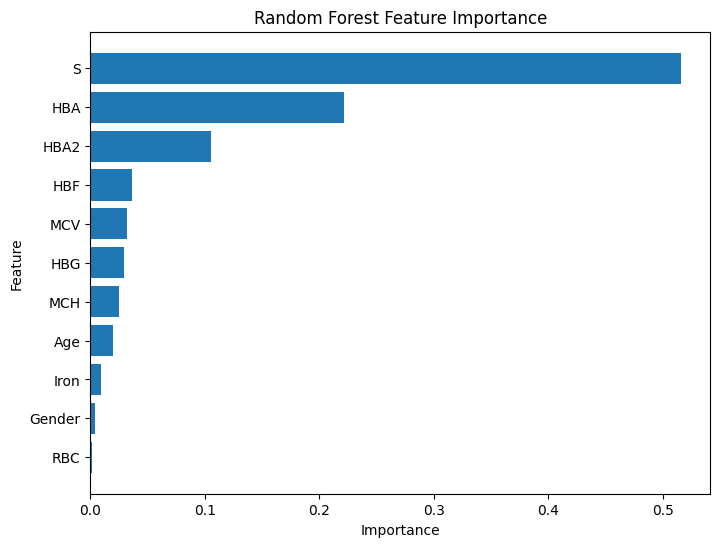

In [38]:
# Train Random Forest on the full dataset
rf_final = RandomForestClassifier(n_estimators=200, random_state=42)
rf_final.fit(X_scaled, y)

# Feature importance
importances = rf_final.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature importances:")
display(feature_importance_df)

# Optional: visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()


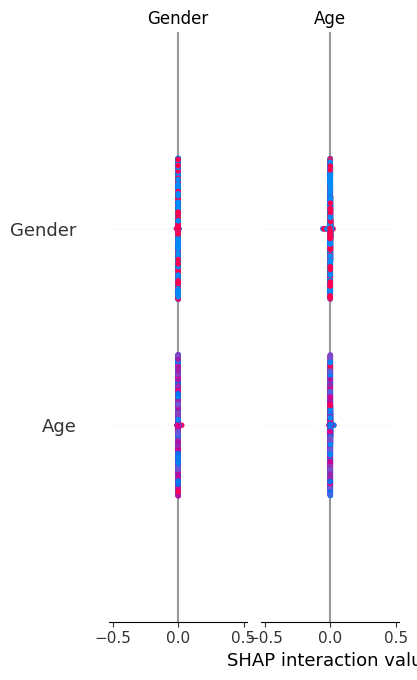

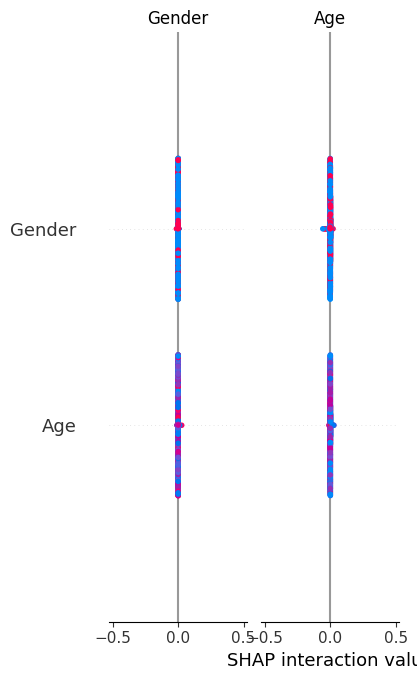

In [40]:
# Retrain a final model on the whole dataset for SHAP analysis
from sklearn.ensemble import RandomForestClassifier

final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_scaled, y)

import shap
shap.initjs()

# Create SHAP explainer for this model
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_scaled)

# Global feature importance
shap.summary_plot(shap_values, X_scaled, plot_type="bar", show=True)

# Detailed beeswarm plot
shap.summary_plot(shap_values, X_scaled, show=True)

In [41]:
# 1) Create train / validation / test splits (stratified)
from sklearn.model_selection import train_test_split
import numpy as np

# If X (raw features) and y (target) are not defined, create them from df
if 'X' not in globals() or 'y' not in globals():
    X = df.drop(columns=['Target'])
    y = df['Target']

# Split: 60% train, 20% val, 20% test (preserves class ratios)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Shapes:")
print(" X_train:", X_train.shape)
print(" X_valid:", X_valid.shape)
print(" X_test: ", X_test.shape)
print("Class distribution (train):")
print(y_train.value_counts(normalize=True))


Shapes:
 X_train: (643, 11)
 X_valid: (215, 11)
 X_test:  (215, 11)
Class distribution (train):
Target
0    0.982893
1    0.017107
Name: proportion, dtype: float64


In [42]:
# 2) GridSearchCV for RandomForest with regularizing hyperparameters
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib
import numpy as np

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [3, 5, 8, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 3, 5],
    'rf__max_features': ['sqrt', 0.5, 0.8]
}

grid = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit grid on the training set
grid.fit(X_train, y_train)
print("Best params (on train):", grid.best_params_)
print("Best CV score (on train folds):", grid.best_score_)

# Evaluate best estimator on validation set
best_on_train = grid.best_estimator_
yv_pred_proba = best_on_train.predict_proba(X_valid)[:,1]
from sklearn.metrics import roc_auc_score
val_auc = roc_auc_score(y_valid, yv_pred_proba)
print("Validation ROC-AUC:", val_auc)

# Refit best estimator on train + valid for final evaluation on held-out test set
X_trainval = np.vstack([X_train.values, X_valid.values])
y_trainval = np.concatenate([y_train.values, y_valid.values])
# Refit pipeline on combined training+validation (but easier: use best params to create final pipeline)
best_params = grid.best_params_
final_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=best_params['rf__n_estimators'],
        max_depth=best_params['rf__max_depth'],
        min_samples_split=best_params['rf__min_samples_split'],
        min_samples_leaf=best_params['rf__min_samples_leaf'],
        max_features=best_params['rf__max_features'],
        random_state=42,
        n_jobs=-1
    ))
])

# Fit final model on train+valid
final_rf.fit(np.vstack([X_train.values, X_valid.values]), np.concatenate([y_train.values, y_valid.values]))
print("Final Random Forest fitted on train + validation.")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params (on train): {'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best CV score (on train folds): 1.0
Validation ROC-AUC: 1.0
Final Random Forest fitted on train + validation.


In [43]:
# 3) Baseline logistic regression with simple regularization grid
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=2000, solver='liblinear'))  # liblinear for small datasets
])

param_grid_lr = {
    'lr__C': [0.01, 0.1, 1.0, 10.0],
    'lr__penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train, y_train)
print("Best LR params:", grid_lr.best_params_)
print("Best LR CV ROC-AUC:", grid_lr.best_score_)

# Final LR fit on train+valid using best params
best_lr_params = grid_lr.best_params_
final_lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(
    max_iter=2000, solver='liblinear', C=best_lr_params['lr__C'], penalty=best_lr_params['lr__penalty']
))])
final_lr.fit(np.vstack([X_train.values, X_valid.values]), np.concatenate([y_train.values, y_valid.values]))
print("Final Logistic Regression fitted on train + validation.")


Best LR params: {'lr__C': 1.0, 'lr__penalty': 'l2'}
Best LR CV ROC-AUC: 0.8952505936757905
Final Logistic Regression fitted on train + validation.


In [44]:
# 4) Feature selection using RFE with logistic regression (optional)
from sklearn.feature_selection import RFE

selector_estimator = LogisticRegression(max_iter=2000, solver='liblinear')
# choose number of features (e.g., 5)
n_features = 5
rfe = RFE(selector_estimator, n_features_to_select=n_features, step=1)
rfe.fit(X_train, y_train)
selected = X.columns[rfe.support_].tolist()
print("Selected features by RFE:", selected)

# Rebuild final pipelines restricted to selected features
final_rf_reduced = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=42, **{
    'n_estimators': final_rf.named_steps['rf'].n_estimators,
    'max_depth': final_rf.named_steps['rf'].max_depth,
    'min_samples_split': final_rf.named_steps['rf'].min_samples_split,
    'min_samples_leaf': final_rf.named_steps['rf'].min_samples_leaf,
    'max_features': final_rf.named_steps['rf'].max_features
}))])
# fit on reduced X
final_rf_reduced.fit(np.vstack([X_train[selected].values, X_valid[selected].values]),
                     np.concatenate([y_train.values, y_valid.values]))

print("Reduced RF fitted on selected features.")


Selected features by RFE: ['RBC', 'S', 'HBA', 'HBF', 'Iron']
Reduced RF fitted on selected features.


--- Random Forest (final) ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       211
           1       1.00      0.50      0.67         4

    accuracy                           0.99       215
   macro avg       1.00      0.75      0.83       215
weighted avg       0.99      0.99      0.99       215

ROC-AUC: 1.0
Confusion Matrix:
 [[211   0]
 [  2   2]]
--- Logistic Regression (final) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       211
           1       0.50      0.50      0.50         4

    accuracy                           0.98       215
   macro avg       0.75      0.75      0.75       215
weighted avg       0.98      0.98      0.98       215

ROC-AUC: 0.740521327014218
Confusion Matrix:
 [[209   2]
 [  2   2]]
--- Random Forest (reduced features) ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       211
      

/Users/konstantinoskalaitzidis/Developer/thalassemia-diagnosis/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/konstantinoskalaitzidis/Developer/thalassemia-diagnosis/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/konstantinoskalaitzidis/Developer/thalassemia-diagnosis/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/konstantinoskalaitzidis/Developer/thalassemia-diagnosis/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/konstantinoskalaitzidis/Developer/thalassemia-diagnos

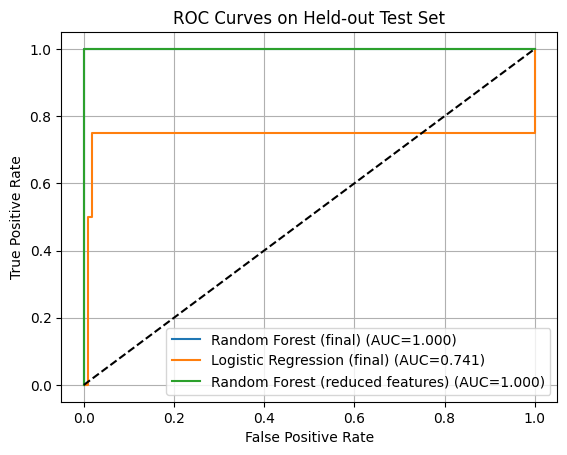

In [45]:
# 5) Evaluate final models on the held-out test set
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def evaluate_model(model, X_test_df, y_test, name="Model"):
    y_pred = model.predict(X_test_df)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_df)[:,1]
    else:
        # fallback
        y_prob = model.decision_function(X_test_df)
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")

# Evaluate RF (full features)
evaluate_model(final_rf, X_test, y_test, name="Random Forest (final)")

# Evaluate LR (full features)
evaluate_model(final_lr, X_test, y_test, name="Logistic Regression (final)")

# Evaluate RF reduced (selected features) if available
try:
    evaluate_model(final_rf_reduced, X_test[selected], y_test, name="Random Forest (reduced features)")
except Exception:
    pass

# Plot combined ROC
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Held-out Test Set")
plt.legend()
plt.grid(True)
plt.show()
